In [1]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
from rosa.predict import  predict


# BASE_DIR = "/Users/nsofroniew/Documents/data/rosa/outputs/gene/2023-01-26/15-52-03"
BASE_DIR = "/home/ec2-user/enformer/outputs/gene/2023-01-28/19-20-52"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    cfg = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = BASE_DIR + "/checkpoints/*.ckpt"
    chkpt = glob(chkpts)[1]

    adata = predict(cfg, chkpt)

display(adata)

Global seed set to 0
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/tmp/ipykernel_2794/4231529086.py:11: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


RosaLightningModule(
  (model): RosaModel(
    (model): SingleHead(
      (fc): Linear(in_features=3072, out_features=177, bias=True)
    )
  )
)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Missing logger folder: /home/ec2-user/rosa/notebooks/lightning_logs
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 177 × 19429
    obs: 'cell_type', 'count', 'tissue', 'label', 'train', 'marker_gene', 'marker_feature_name'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'external_gene_name', 'gene_biotype', 'column_1', 'column_2', 'column_3', 'column_4', 'train', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_label', 'embedding_pca', 'hvg', 'log1p'
    obsm: 'bin_edges', 'embedding'
    varm: 'embedding', 'embedding_pca'
    layers: 'binned', 'counts', 'log1p', 'normalized_counts', 'prediction'

In [2]:
from rosa.score import score_predictions
from rosa.plotting import plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))



        mean spearmanr across genes 0.689
        mean spearmanr across cells 0.412
        mean square error 0.539
        ks-statistic on total expression 0.243
        mean percent total expression captured per cell 43.004
        


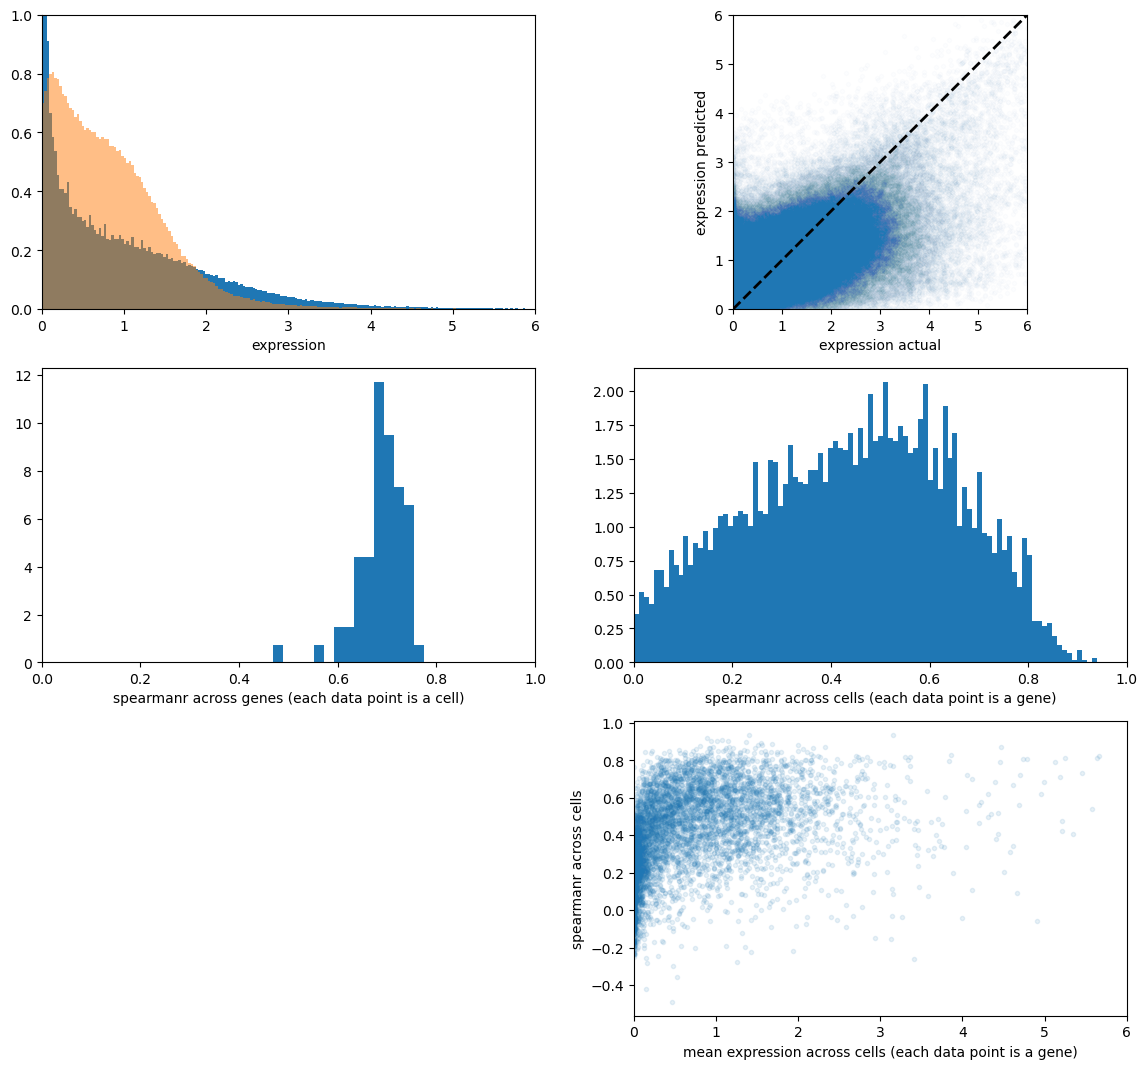

In [3]:
plot_expression_and_correlation(adata_test, results)

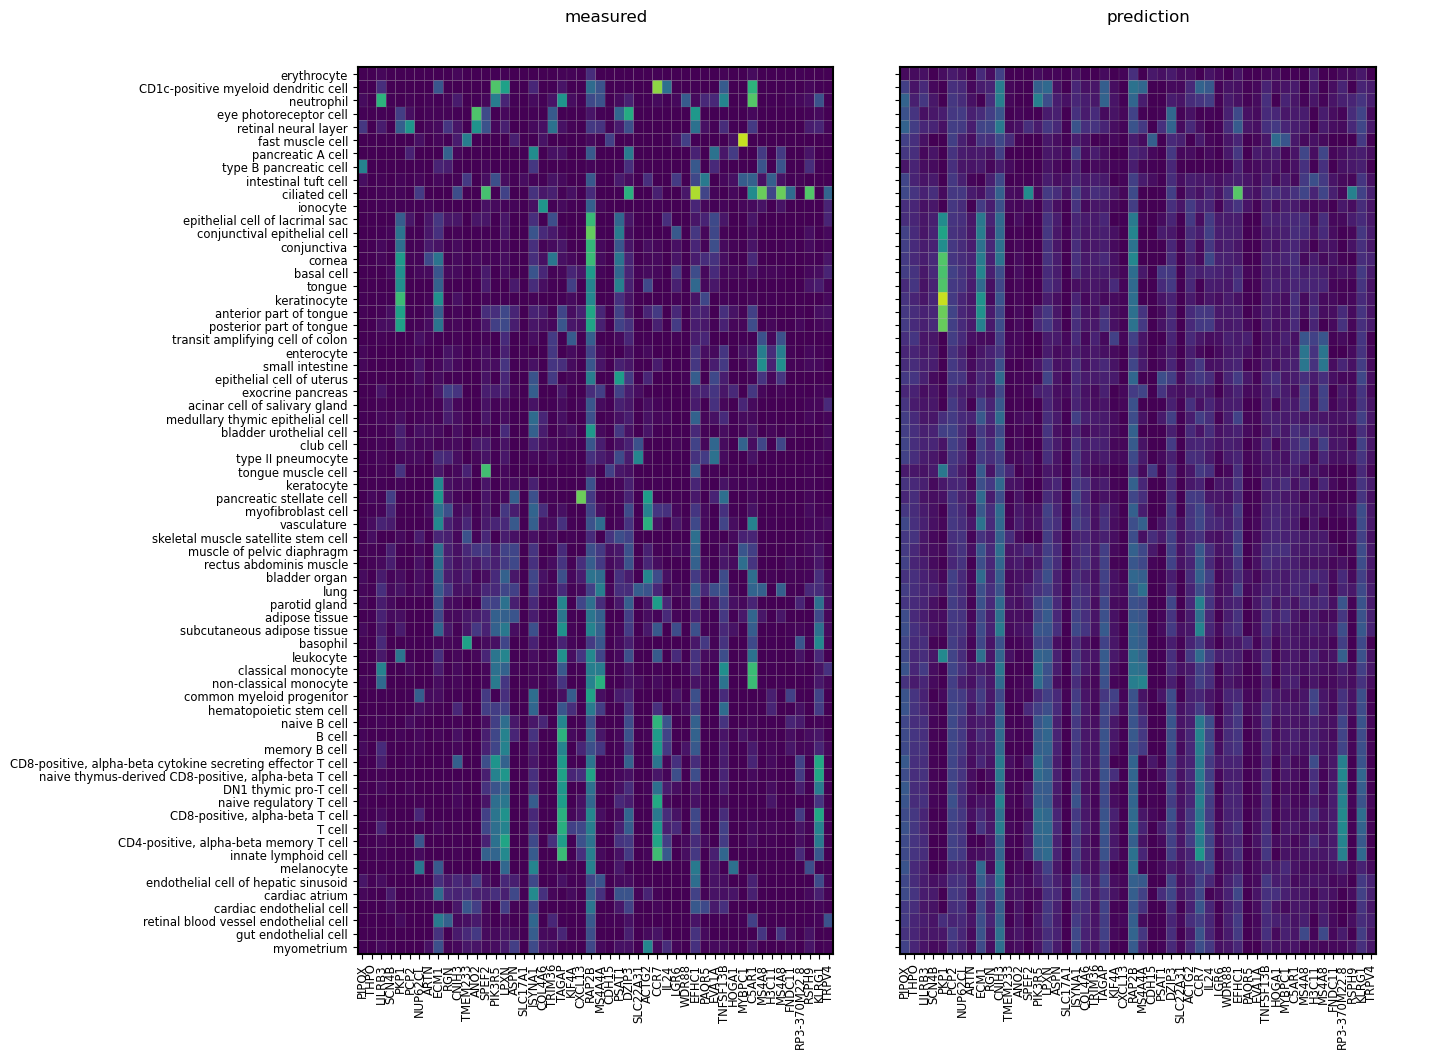

In [4]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

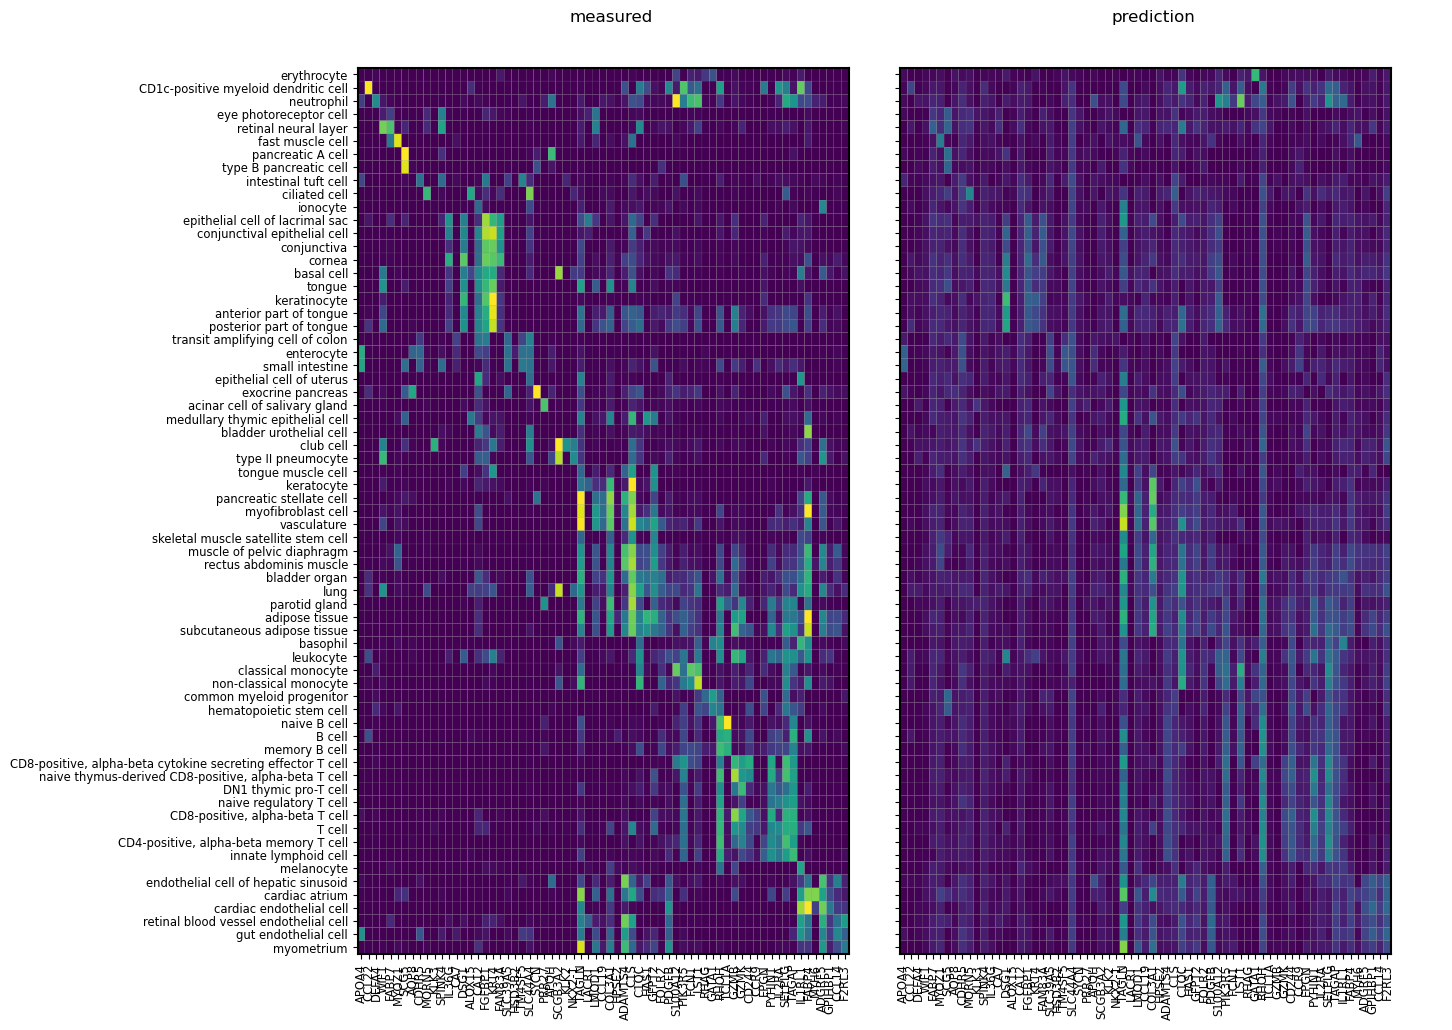

In [5]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)